# K-Means
One of the methods described in the paper was using K-Means. When imputing using K-Means, you take the k closest samples (based on a certain distance measure) and take the mean of the values of the features in those samples. This gives you a complete vector, which you can use your classifier on. Instead of imputation, it's also possible to use K-means immediately for predicting. You search the k-closest samples and let them vote for the class your test sample should be.

## K-Means imputation
Let's impute the missing values using K-Means and predict using a random forest classifier.

Imputing must be done after get_features, because distance function often work better on numbers.

In [5]:
# We're lucky, sklearn already has a KNNImputer built in: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from util import get_train_dataset, get_features, fix_test

df = get_train_dataset()
# df = df.sample(n=1000)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

x = get_features(df_train)
y = df_train['reaction']

x_test = get_features(df_test,test=True)
y_test = df_test['reaction']

x_test = fix_test(x_test, x.columns)

imputer = KNNImputer(n_neighbors=5)

x_imputed = imputer.fit_transform(x)
x_test_imputed = imputer.transform(x_test)

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


In [6]:
clf = RandomForestClassifier(random_state=42)
clf.fit(x_imputed, y)

RandomForestClassifier(random_state=42)

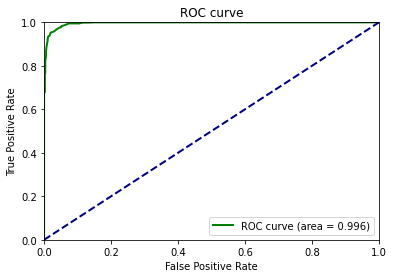

0.9959215654468536

In [7]:
from util import calculate_auc_and_plot
y_pred = clf.predict_proba(x_test_imputed)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


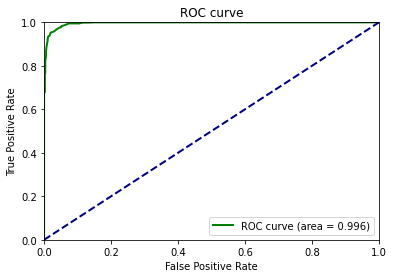

0.9959215654468536

In [8]:
# Way to good accuracy, I noticed test=True wasn't set, so let's see what difference that makes
# Doing this again to reset the one hot encoder (and not use the test version)
x = get_features(df_train)
y = df_train['reaction']


x_test = get_features(df_test, test=True)
y_test = df_test['reaction']

x_test = fix_test(x_test, x.columns)

x_test_imputed = imputer.transform(x_test)

y_pred = clf.predict_proba(x_test_imputed)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

# K-Means prediction

## Imputed data
Let's try it on the imputed data

In [9]:
# For this, we can use the KNNClassifier from sklearn
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)

clf.fit(x_imputed, y)

KNeighborsClassifier()

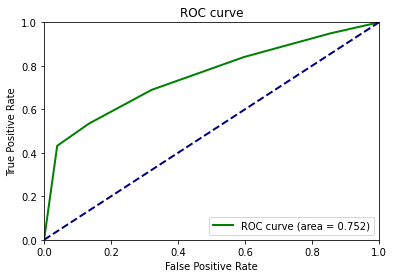

0.7520453725844038

In [10]:
y_pred = clf.predict_proba(x_test_imputed)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

# Immediate prediction

In [18]:
from sklearn.neighbors import KNeighborsClassifier

df = get_train_dataset()
# df = df.sample(n=1000)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

x = get_features(df_train)
y = df_train['reaction']

x_test = get_features(df_test, test=True)
y_test = df_test['reaction']

x_test = fix_test(x_test, x.columns)

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


In [19]:
# For the classifier to work, we need to remove the Nan's, let's try filling them with 0
x_zero_imputed = x.fillna(0)
x_test_zero_imputed = x_test.fillna(0)

In [20]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(x_zero_imputed, y)

KNeighborsClassifier()

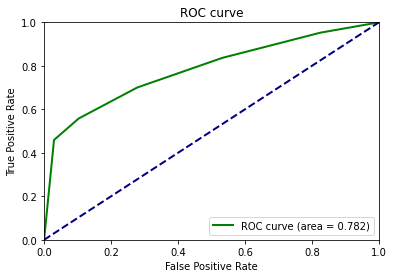

0.7821795872612647

In [21]:
y_pred = clf.predict_proba(x_test_zero_imputed)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

In [22]:
# Let's try filling them with the mean
from sklearn.impute import SimpleImputer
import numpy as np
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
x_mean_imputed = imp_mean.fit_transform(x)
x_test_mean_imputed = imp_mean.transform(x_test)

In [23]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(x_mean_imputed, y)

KNeighborsClassifier()

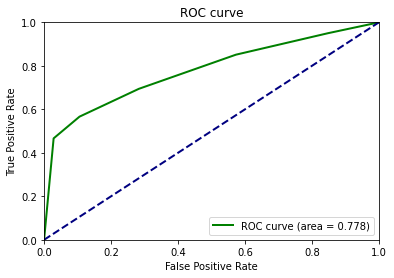

0.778277122096686

In [24]:
y_pred = clf.predict_proba(x_test_mean_imputed)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

# Summary
When first converting the dataset into feature and then imputing the missing values using a KNNImputer, we get (using random forest) an AUC of 0.837 (or 0.987 when generating features without Test=True). 0.837 is sligthly worse than the AUC I get when not using imputation and filling the NaN's with 0 (AUC=0.871).

The KNeigborsClassifier didn't support missing values, so I tried different ways to impute then, to classify them afterwards with the KNeigborsClassifier. Imputing using KNNImputer gave an AUC of 0.75, zeros 0.811 and the mean 0.791.